In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.sandbox.stats.multicomp import multipletests

___________
Cкачаем данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все признаки, кроме `Class`.

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [ ]:
data = pd.read_csv('wine/wine.data', header=None)
data.columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
                'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
data = data.drop('Class', axis=1)

Для каждого из признаков нарисуем Q-Q plot. Для наглядности и экономии места будем рисовать графики в несколько столбцов, используя `plt.subplot`.

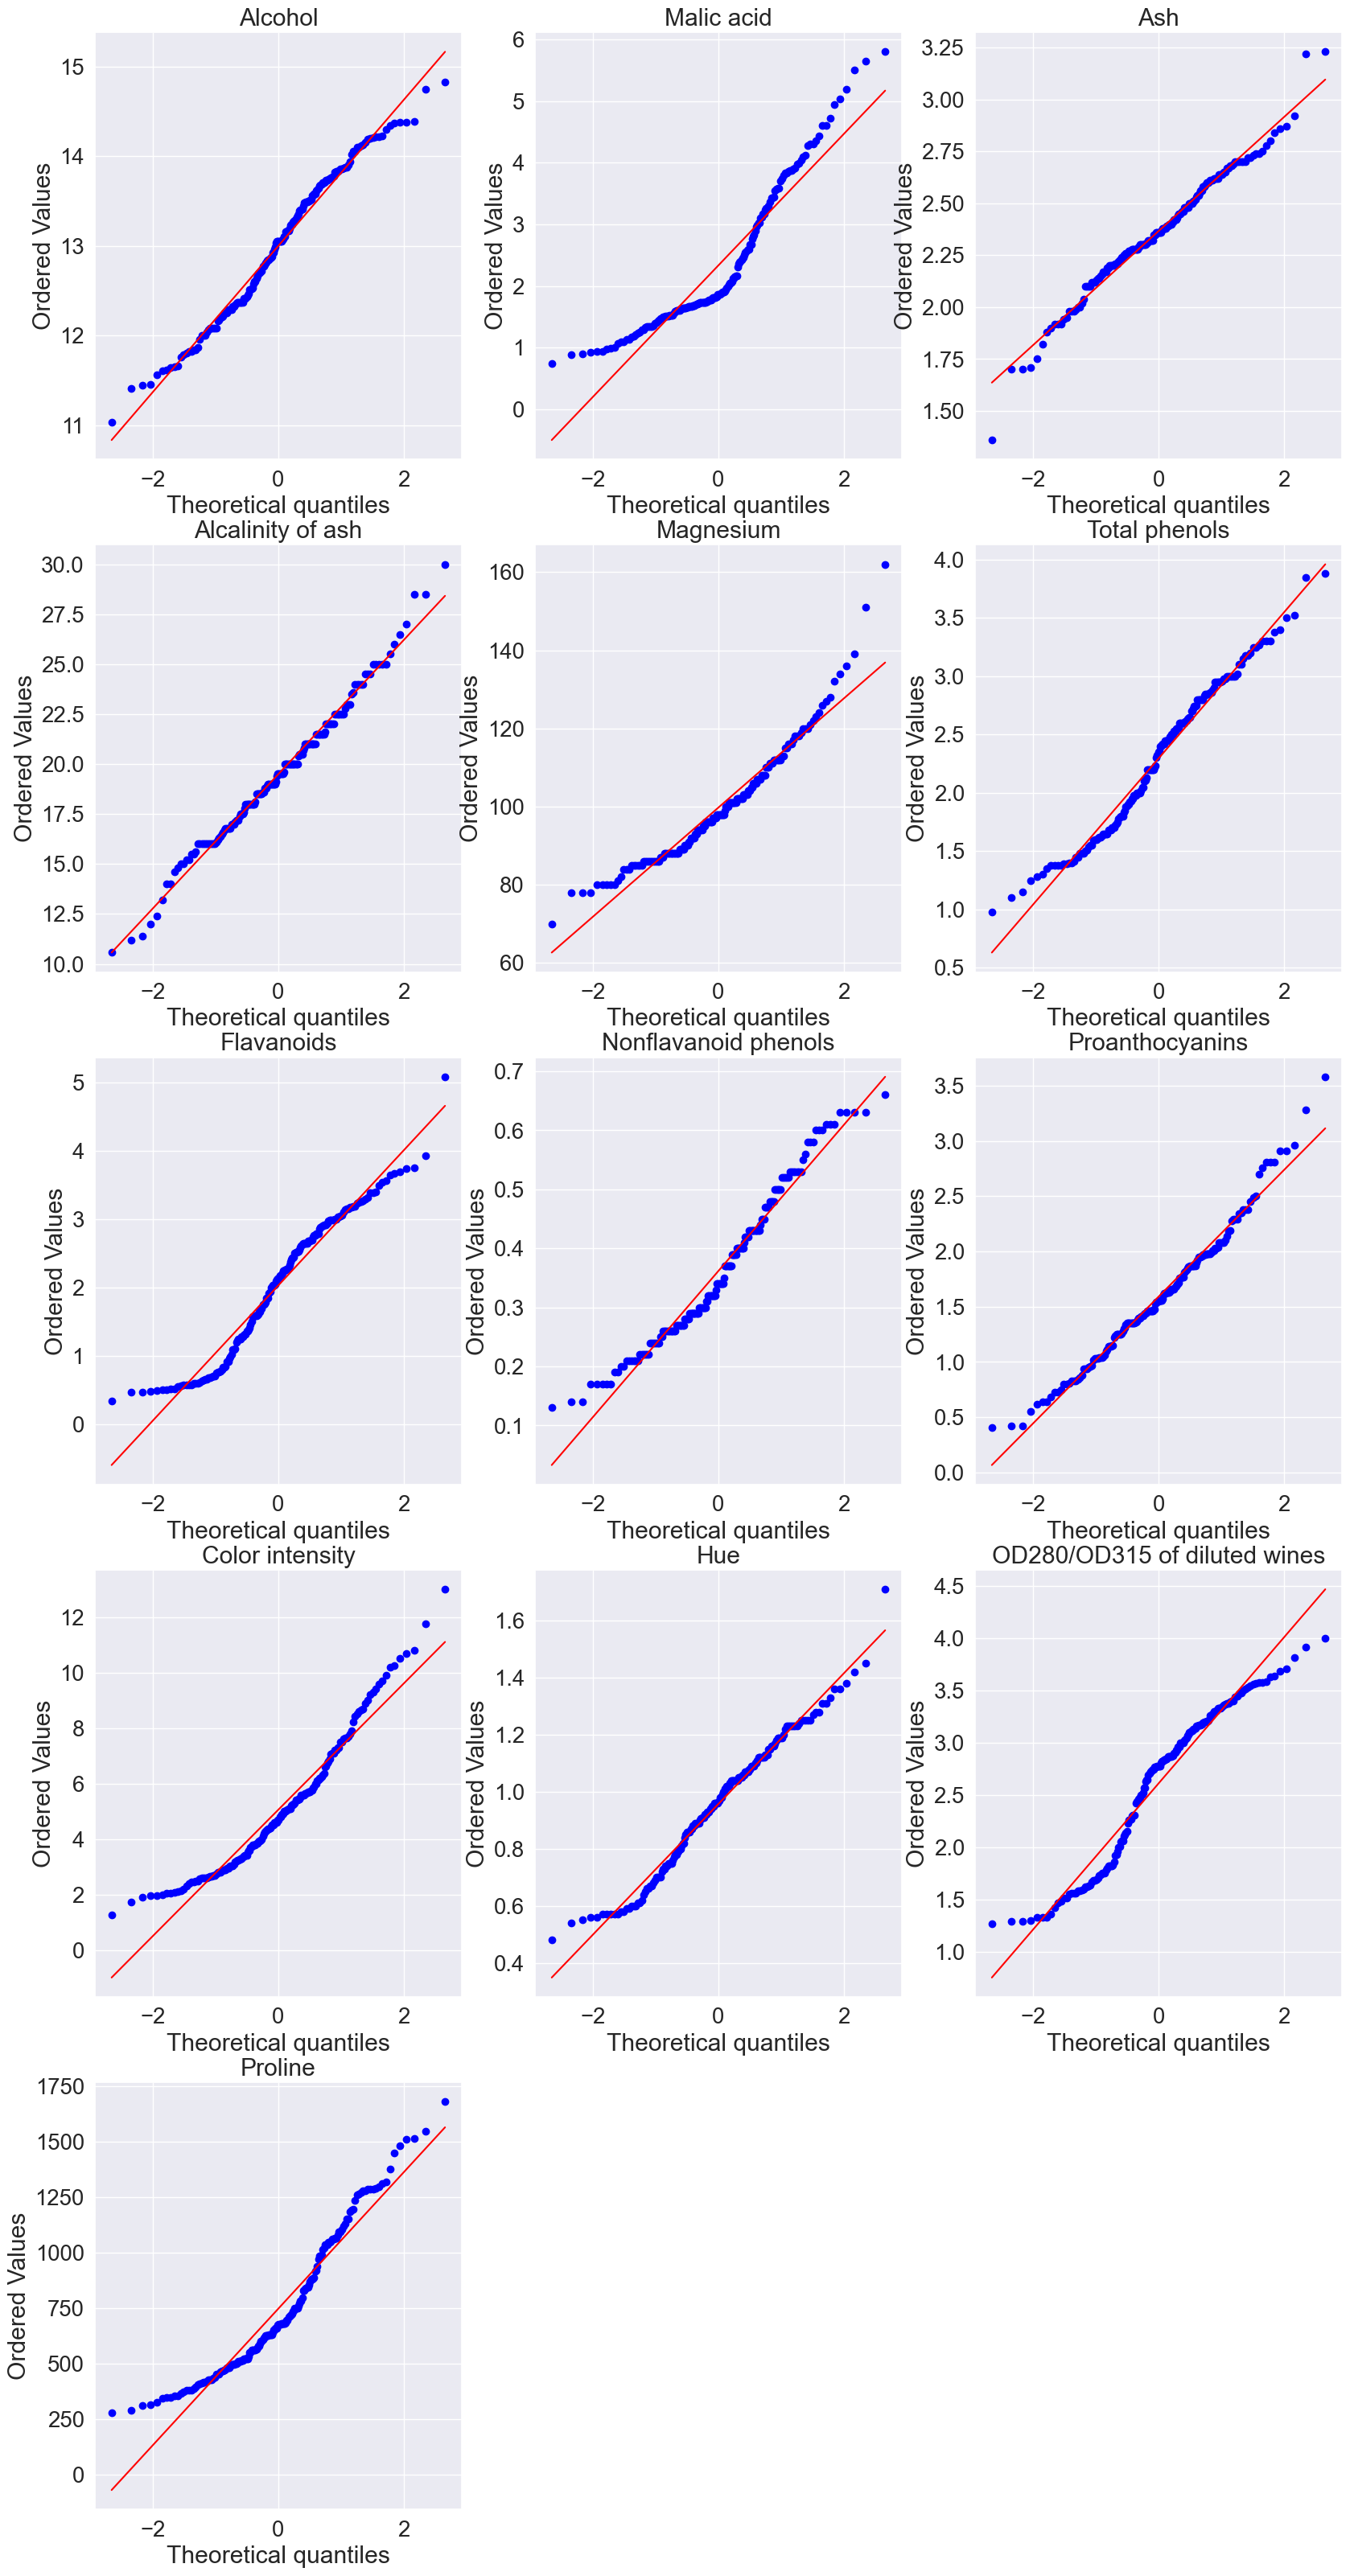

In [ ]:
plt.figure(figsize=(20, 40))
for i in range(data.shape[1]):
    sps.probplot(data.iloc[:, i], plot=plt.subplot(5, 3, i+1))
    plt.title(data.columns[i])
plt.show()

Для каких признаков можно говорить об их нормальности и почему?

**Ответ:**  

Точно можно говорить о нормальности **Ash, Alcalinity of ash, Proanthocyanins**, еще некоторые под сомнением.

Проверим нормальность каждого признака статистическими критериями. Прежде чем выполнить следующую часть задачи, ответим на вопросы.

Для каждого признака используем несколько критериев проверки нормальности. Какие критерии стоит использовать?

**Ответ:**  Точно стоит использовать Шапиро-Уилка и Жарка-Бера.

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех признаков и всех критериев сразу. Почему так нужно делать?

**Ответ:** Мы делаем общие выводы, и хотим, чтобы вероятность допустить хотя бы одну ошибку 1 рода (FWER) была не больше 0.05. Если для разных групп будем делать разные серии, то можем гарантировать это свойство только внутри каждой серии. При объединении результатов ошибка может увеличится.

Какой метод для контроля FWER стоит применить и почему?

**Ответ:** Метод Холма, т.к. он мощнее метода Бонферрони и применим во всех случаях. Методы типа Шидака применять нельзя, поскольку статистики зависимы.

Как понять из результата процедуры множественной проверки гипотез, нормальность каких признаков следует отклонить?

**Ответ:** Если для признака хотя бы один критерий (по этому признаку) ПОСЛЕ МПГ отвергает гипотезу, то нужно отвергать. Об этом была теоретическая задача.

Если нормальность не отклоняется, что можно сказать про выборку? Ответ находится в презентации с лекции.

**Ответ:** Данные согласуются с нормальностью.

Реализуем данную схему. Предварительно собрав p-value всех критериев в таблицу.

In [ ]:
# массивы для сохранения значений pvalue
shapiros_pvalues = np.zeros(data.shape[1])
jarque_beras_pvalues = np.zeros(data.shape[1])

# цикл по признакам
for i, column in enumerate(data):
    sample = data[column]  # выборка
    # применение критерия и сохранение pvalue
    shapiros_pvalues[i] = sps.shapiro(sample)[1]
    jarque_beras_pvalues[i] = sps.jarque_bera(sample)[1]

Посмотрим на таблицу с pvalue.

In [ ]:
pvalue_table = pd.DataFrame({
    'Шапиро-Уилка p-value' : shapiros_pvalues,
    'Жарка-Бера p-value' : jarque_beras_pvalues},
    index=data.columns)
pvalue_table

,Шапиро-Уилка p-value,Жарка-Бера p-value
Alcohol,2.005071e-02,6.106775e-02
Malic acid,2.945822e-10,1.115426e-07
Ash,3.869102e-02,8.485917e-03
Alcalinity of ash,2.639486e-01,2.509338e-01
Magnesium,6.345416e-07,6.883383e-15
Total phenols,4.394717e-03,6.312188e-02
Flavanoids,1.679064e-05,5.273120e-02
Nonflavanoid phenols,1.055268e-04,1.071359e-02
Proanthocyanins,1.445252e-02,7.840977e-03
Color intensity,9.230111e-07,1.092262e-05


Выполним МПГ методом Холма и составим сравнительную таблицу результатов.

In [ ]:
results = multipletests(pvalue_table.values.ravel(),
                        method='holm',
                        alpha=0.05)[0].reshape((13, 2))
test_result = pd.DataFrame(results,
                           columns=['Отвергается, Шапиро-Уилка',
                                    'Отвергается, Жарка-Бера'],
                           index=data.columns)
test_result

,"Отвергается, Шапиро-Уилка","Отвергается, Жарка-Бера"
Alcohol,False,False
Malic acid,True,True
Ash,False,False
Alcalinity of ash,False,False
Magnesium,True,True
Total phenols,False,False
Flavanoids,True,False
Nonflavanoid phenols,True,False
Proanthocyanins,False,False
Color intensity,True,True


Для каких признаков нормальность не отвергается?

**Ответ:**  Для которых строка имеет вид `[False, False]`, т.е. для **Alcohol, Ash, Alcalinity of ash, Total phenols, Proanthocyanins, Hue**.

**Вывод:** Предположения, основанные на Q-Q plot хорошо соотносятся c результатами МПГ. Небольшие наблюдения с помощью Q-Q plot позволяют говорить о **возможной нормальности** некоторых признаков почти сразу, без сложных процедур МПГ. Уже после таких быстрых наблюдений можно ставить соответствующие гипотезы и проверять их.